In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import scipy.io
from skimage.transform import resize
import matplotlib.pyplot as plt
import warnings 
import sys
import pdb, os
import matplotlib.pyplot as plt
from scipy import misc
import scipy.ndimage as ndimage
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import imageio
from scipy import linalg
from PIL import Image
import scipy.ndimage as ndi
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from tqdm.notebook import tqdm
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
%cd /content/drive/MyDrive/ML_Project/EDPCNN-master

/content/drive/MyDrive/ML_Project/EDPCNN-master


In [ ]:
image_path = "/content/drive/MyDrive/ML_Project/data/BBBC003_v1_images/mouse_embryos_dic_images"
mask_path = "/content/drive/MyDrive/ML_Project/data/BBBC003_v1_images/mouse_embryos_dic_foreground"
image_name = os.listdir(image_path)
mask_name = os.listdir(mask_path)

IMG_WIDTH = 212
IMG_HEIGHT = 212

In [ ]:
X_train = np.zeros((len(image_name), IMG_HEIGHT, IMG_WIDTH), dtype=np.float32)
Y_train = np.zeros((len(mask_name), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)

In [ ]:
for n, id_ in enumerate(image_name):
    path = image_path + "/" + id_
    img = imread(path, plugin = 'pil')
    
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

    X_train[n] = img

for n, id_ in enumerate(mask_name):    
    path = mask_path + "/" + id_
    mask = imread(path, plugin = 'pil')
    
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

    Y_train[n] = mask

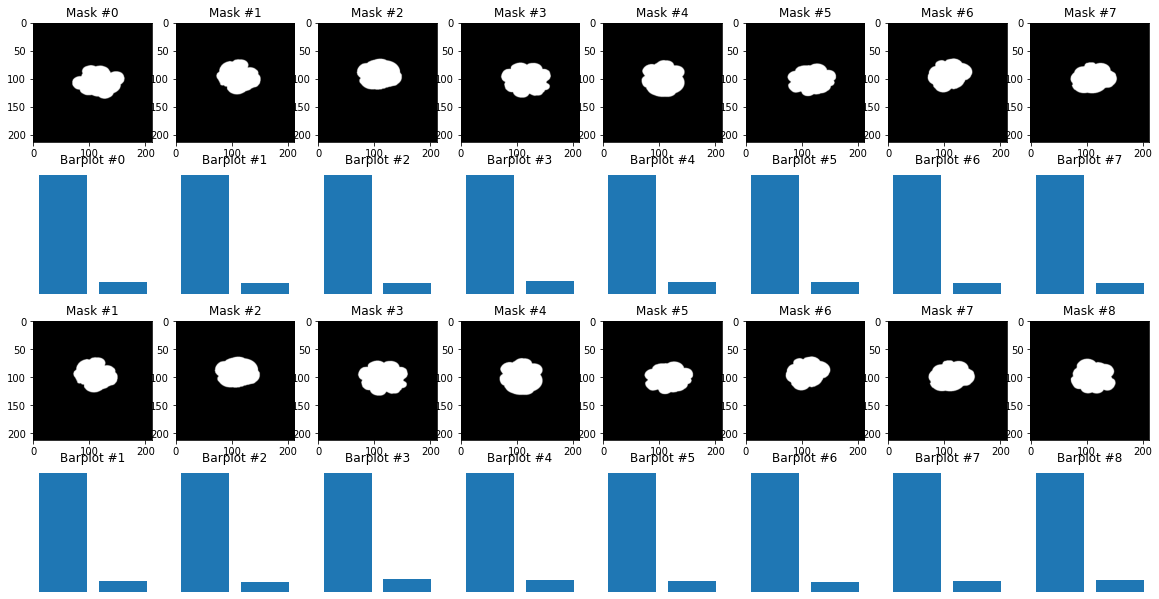

In [ ]:
# Illustrate the train images and masks

plt.figure(figsize=(20,16))
x, y = 8,2
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i + j
        plt.imshow(X_train[pos],'gray')
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*3, x, (i*2+1)*x+j+1)
        
        #We display the associated mask we just generated above with the training image
        plt.imshow(Y_train[pos],'gray')
        plt.title('Mask #{}'.format(pos))
        mask0 = np.sum(Y_train[pos] == 0)/(Y_train[pos].shape[0]*Y_train[pos].shape[1])
        mask1 = 1 - mask0

        plt.subplot(y*3, x, (i*2+2)*x+j+1)
        plt.bar([0,1],[mask0,mask1])
#        prob.append([mask0,mask1])
        plt.title('Barplot #{}'.format(pos))
        
        plt.axis('off')
        
plt.show()

In [ ]:
a.shape

NameError: ignored

In [ ]:
type(Y_train[0][1,2])

numpy.uint8

In [ ]:
transform_test = transforms.Compose( 
    [transforms.Resize((212,212)),
    transforms.ToTensor()]
)
                                                            
transform_train = transforms.Compose(
    [transforms.Resize(212),
    transforms.RandomRotation(180),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(180,(0.2,0.2),(0.0001,0.2)),
    transforms.CenterCrop(212),
    transforms.ToTensor()]
    )

In [ ]:
class Dataiter(Dataset):

    def __init__(self, image_path, mask_path, mode = 'train', transform = None):
        #self.img_width = 212
        #self.img_height = 212
        self.image_path = image_path
        self.mask_path = mask_path
        self.train_ids = os.listdir(image_path)[:12]
        self.test_ids = os.listdir(image_path)[12:15]
        self.mode = mode        
        self.transform = transform

    def __len__(self):
      if self.mode == 'train':
        return len(self.train_ids)
      else:
        return len(self.test_ids)

    def __getitem__(self, idx):
      if self.mode == 'train':
        id_ = self.train_ids[idx]
      else:
        id_ = self.test_ids[idx]

      imagepath = self.image_path + "/" + id_
      print("id",id_)
      img = imread(imagepath, plugin = 'pil')
      print("img shape",img.shape)
      print(type(img))
      #img = resize(img, (self.img_height,self.img_width), mode='constant', preserve_range=True)
      
      #X = np.asarray(img, dtype = 'float32')
  
      maskpath = self.mask_path + "/" + id_
      mask = imread(maskpath, plugin = 'pil')
      print("mask shape",mask.shape)
      print(type(mask))
      #mask = resize(mask, (self.img_height,self.img_width), mode='constant', preserve_range=True)

      #Y = np.asarray(mask, dtype = 'float32')

      #sample = {'image': X, 'mask': Y}
      #to_pil_image = transforms.ToPILImage()
      #to_tensor = transforms.ToTensor()
      
      if self.transform:
        #sample = self.transform(sample)
        X = self.transform(torch.from_numpy(img))
        Y = self.transform(torch.from_numpy(mask))

      #return sample['image'], sample['mask']
      return X, Y

In [ ]:
train_data = Dataiter(image_path, mask_path, mode = 'train', transform = transform_train)
test_data = Dataiter(image_path, mask_path, mode = 'test', transform = transform_test)
#data[0][0].shape
print(len(train_data))
print(len(test_data))

12
3


In [ ]:
from tqdm import tqdm
for i in tqdm(train_data):
  print(i)

#train_data


  0%|          | 0/12 [00:00<?, ?it/s]

id 7_19_M1E3.tif
img shape (640, 480)
<class 'numpy.ndarray'>
mask shape (640, 480)
<class 'numpy.ndarray'>


ValueError: ignored

In [ ]:
valid_size = 0.25
batch_size = 5

indices = list(range(len(train_data)))
np.random.shuffle(indices)
split = int(np.floor((valid_size * len(train_data))))
valid_idx , train_idx = indices[:split] , indices[split:]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_data,batch_size = 5,num_workers=0,sampler = train_sampler) 
valid_loader = DataLoader(train_data,batch_size = 5,num_workers=0,sampler = valid_sampler)
test_loader = DataLoader(test_data,batch_size=1,shuffle=False)  

In [ ]:
d_iter = iter(train_loader)
print(d_iter)
#imgs, labels = next(d_iter)

In [ ]:
k = 0
for batch_idx, (data, target) in enumerate(train_loader):
  print(data.shape)
  print(target.shape)
  print(batch_idx)
  print(k)
  k+=1
  print("-------------------------------")


id 7_19_M2E8.tif
img shape (640, 480)
<class 'numpy.ndarray'>
mask shape (640, 480)
<class 'numpy.ndarray'>


ValueError: ignored

In [ ]:
def get_center_of_mass(mask, index):
    # return center of mass
    # output will be in (row, col) order
    center = scipy.ndimage.measurements.center_of_mass(np.ones_like(mask), mask, index)
    center = np.asarray(center)
    return center

#lbl = ndimage.label(Y)[0]
get_center_of_mass(Y, 1)

NameError: ignored

In [ ]:
%cd /content/drive/MyDrive/ML_Project/EDPCNN-master

/content/drive/MyDrive/ML_Project/EDPCNN-master


In [ ]:
ls

acdc/                imgs/              preproc_data/  sys_config.py
_config.yml          losses.py          __pycache__/   train_edpcnn.py
data_iterator.py     metrics_acdc.py    README.md      train_unet.py
evaluate_edpcnn.py   network.py         run_edpcnn.py  utils.py
evaluate_unet+dp.py  our_data_iter.py   run_unet.py    visualize/
evaluate_unet.py     our_train_unet.py  snake/         visualize.jpg


In [ ]:
from our_data_iter import Dataset
from skimage.io import imread 

d = Dataset()
print("Finished")

import matplotlib

#matplotlib.use("Agg")
import matplotlib.pyplot as plt
%matplotlib inline

fig1 = plt.figure(figsize = (15,15))
for j in range(0,5,1):
  img = d.train_set.images[j].squeeze()
  fig1.add_subplot(1, 5, j+1)
  plt.imshow(img, cmap=plt.cm.gray)
plt.savefig("/content/drive/MyDrive/ML_Project/EDPCNN-master/visualize.jpg")

fig2 = plt.figure(figsize = (15,15))
for j in range(0,5,1):
  mask = d.train_set.masks[j]
  center = d.train_set.centers[j]
  fig2.add_subplot(1, 5, j+1)
  plt.imshow(mask, alpha=1.0, cmap=plt.cm.gray)
  plt.scatter(center[1], center[0], color="r", marker="x", s=1)
plt.savefig("/content/drive/MyDrive/ML_Project/EDPCNN-master/visualize.jpg")

plt.show()

NameError: ignored

In [ ]:
!pwd

/content/drive/My Drive/ML_Project/EDPCNN-master


In [ ]:
!pip install tensorboardx

     |████████████████████████████████| 122kB 4.3MB/s 


In [ ]:
!pip install tensorboardX

In [ ]:
!pip install tensorboard

In [ ]:
!pip install warmup-scheduler

  Created wheel for warmup-scheduler: filename=warmup_scheduler-0.3-cp37-none-any.whl size=2983 sha256=5592dd90b7af5706cc240e1593a2fb54706df07dd22498f35ea936a243103141
  Stored in directory: /root/.cache/pip/wheels/64/4c/48/155aa3eb9e11a88ebf903a1ab8d8149458b36b318f76b92244
Successfully built warmup-scheduler


In [ ]:
!touch our_data_iter.py

In [ ]:
!ls

drive  our_data_iter.py  sample_data


In [ ]:
!ls

mouse_embryos_dic_foreground  mouse_embryos_dic_images	our_data_iter.py


In [ ]:
%cd /content/drive/MyDrive/ML_Project/EDPCNN-master

/content/drive/MyDrive/ML_Project/EDPCNN-master


In [ ]:
!ls

acdc		     imgs		run_edpcnn.py	 utils.py
_config.yml	     losses.py		run_unet.py	 visualize
data_iterator.py     metrics_acdc.py	snake		 visualize.jpg
evaluate_edpcnn.py   network.py		sys_config.py
evaluate_unet+dp.py  our_train_unet.py	train_edpcnn.py
evaluate_unet.py     README.md		train_unet.py


In [ ]:
from our_train_unet import main

In [ ]:
import pandas as pd

args = pd.Series({'seed': 0,
                 'lr': 1e-4,
                 'n_epochs': 1,
                 'weight_decay': 0.0,
                 'batch_sz': 5,
                 'log_freq': 10,
                 'train_eval_freq': 10,
                 'val_eval_freq': 10,
                 'train_set_sz': 12,
                 'num_cls': 1,
                 'log_dir': 'log/unet-1_cls/ours',
                 'load_pretrained':0,
                 'use_ce': 1})

In [ ]:
par = main(args)

Keys in dataset:  []


KeyError: ignored